# Table of Contents
 <p><div class="lev1 toc-item"><a data-toc-modified-id="simple-divergence-model-1" href="#simple-divergence-model"><span class="toc-item-num">1&nbsp;&nbsp;</span>simple divergence model</a></div><div class="lev2 toc-item"><a data-toc-modified-id="plot-11" href="#plot"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>plot</a></div><div class="lev1 toc-item"><a data-toc-modified-id="divergence-with-migration-model-2" href="#divergence-with-migration-model"><span class="toc-item-num">2&nbsp;&nbsp;</span>divergence with migration model</a></div><div class="lev2 toc-item"><a data-toc-modified-id="plot-21" href="#plot"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>plot</a></div><div class="lev2 toc-item"><a data-toc-modified-id="LRT-22" href="#LRT"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>LRT</a></div>

In [1]:
from ipyparallel import Client

cl = Client()

cl.ids

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [2]:
%%px --local

# run whole cell on all engines a well as in the local IPython session

import numpy

import sys

sys.path.insert(0, '/home/claudius/Downloads/dadi')

import dadi

In [3]:
%ll dadiExercises/

total 33676
lrwxrwxrwx 1 claudius       53 Feb 17 15:37 ERY.FOLDED.sfs -> /data3/claudius/Big_Data/ANGSD/SFS/ERY/ERY.FOLDED.sfs
-rw-rw-r-- 1 claudius      499 Mar 24 14:04 ERY.FOLDED.sfs.dadi_format
-rw-rw-r-- 1 claudius      499 Mar 24 14:02 ERY.FOLDED.sfs.dadi_format~
lrwxrwxrwx 1 claudius       37 Feb 18 17:46 EryPar.unfolded.2dsfs -> ../../ANGSD/FST/EryPar.unfolded.2dsfs
-rw-rw-r-- 1 claudius    13051 Feb 18 19:00 EryPar.unfolded.2dsfs.dadi_format
-rw-rw-r-- 1 claudius    13051 Feb 18 18:31 EryPar.unfolded.2dsfs.dadi_format~
drwxrwxr-x 5 claudius     4096 Feb 17 13:45 examples/
-rw-rw-r-- 1 claudius   155251 Mar 22 12:37 example_YRI_CEU.ipynb
-rw-rw-r-- 1 claudius   619699 Apr 20 10:19 First_Steps_with_dadi.ipynb
-rw-rw-r-- 1 claudius     1012 Mar 16 09:54 new.bib
lrwxrwxrwx 1 claudius       53 Feb 17 15:37 PAR.FOLDED.sfs -> /data3/claudius/Big_Data/ANGSD/SFS/PAR/PAR.FOLDED.sfs
-rw-rw-r-- 1 claudius      486 Mar 24 20:08 PAR.FOLDED.sfs.dadi_format
-rw-rw-r-- 1 claudius      450 Mar

In [4]:
%less dadiExercises/EryPar.unfolded.2dsfs.dadi_format

In [5]:
# import 2D unfolded spectrum

sfs2d_unfolded = dadi.Spectrum.from_file('dadiExercises/EryPar.unfolded.2dsfs.dadi_format')

In [6]:
%page sfs2d_unfolded

In [7]:
sfs2d_unfolded.sample_sizes

array([36, 36])

In [8]:
# add population labels
sfs2d_unfolded.pop_ids = ["ery", "par"]

For the estimation of the 2D SFS, `realSFS` has only taken sites that had data from at least 9 individuals in *each* population (see `assembly.sh`, lines 1423 onwards).

In [9]:
# print number of segregating sites in the SFS

sfs2d_unfolded.S()

60573.584426000001

The 2D spectrum contains counts from 60k sites that are variable in *par* or *ery* or both.

In [10]:
import pylab

%matplotlib inline

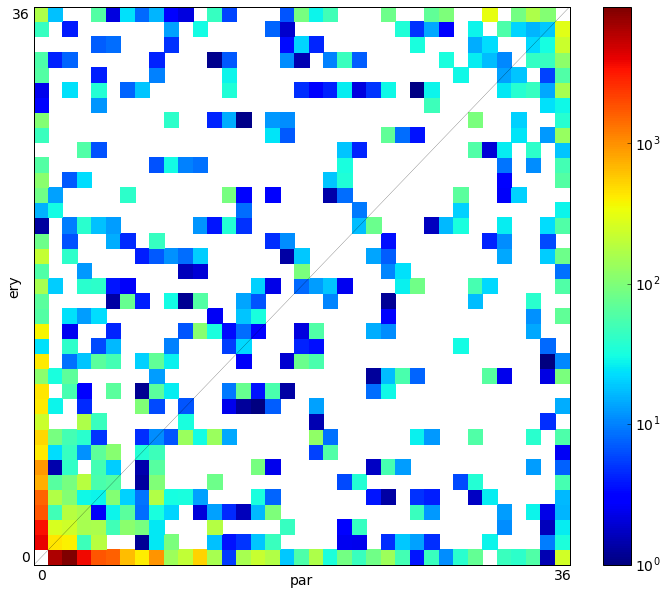

In [11]:
# note this needs to be in the same cell as the dadi plotting function call to take effect
pylab.rcParams['font.size'] = 14.0
pylab.rcParams['figure.figsize'] = [12.0, 10.0]

dadi.Plotting.plot_single_2d_sfs(sfs2d_unfolded, vmin=1, cmap=pylab.cm.jet)

Cells with counts below 1 are masked and appear white in the upper plot.

In [12]:
%psource dadi.Plotting.plot_single_2d_sfs

[More colormaps](http://www.scipy-lectures.org/intro/matplotlib/index.html#colormaps)

In [13]:
sfs2d_folded = sfs2d_unfolded.fold()

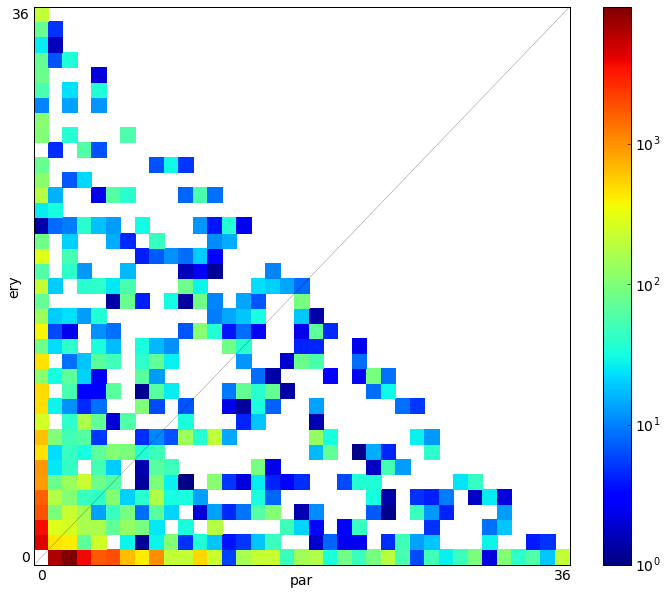

In [14]:
# plot the folded GLOBAL minor allele frequency spectrum

dadi.Plotting.plot_single_2d_sfs(sfs2d_folded, vmin=1, cmap=pylab.cm.jet)

In [15]:
# setting the smallest grid size slightly larger than the largest population sample size (36)
pts_l = [40, 50, 60]

In [16]:
%pinfo dadi.Demographics2D.split_mig

The 1D model fitting has indicated that both _erythropus_ and _parallelus_ underwent population size reduction, maybe starting a long time ago (>400,000 generations).

In [17]:
%psource dadi.Demographics2D.split_mig

In [18]:
%psource dadi.Integration.two_pops

# simple divergence model

In [19]:
def split_nomig(params, ns, pts):
    """
    params = (nu1,nu2,T)
    ns = (n1,n2)

    Split into two populations of specifed size, no migration.

    nu1: Size of population 1 after split.
    nu2: Size of population 2 after split.
    T: Time in the past of split (in units of 2*Na generations) 
    n1,n2: Sample sizes of resulting Spectrum
    pts: Number of grid points to use in integration.
    """
    nu1,nu2,T = params

    xx = dadi.Numerics.default_grid(pts)

    phi = dadi.PhiManip.phi_1D(xx)
    phi = dadi.PhiManip.phi_1D_to_2D(xx, phi)

    phi = dadi.Integration.two_pops(phi, xx, T, nu1, nu2, m12=0, m21=0)

    fs = dadi.Spectrum.from_phi(phi, ns, (xx,xx))
    return fs

In [20]:
cl[:].push(dict(split_nomig=split_nomig))

<AsyncResult: _push>

In [21]:
def run_dadi(p_init): # for the function to be called with map, it needs to have one input variable
    """
    p_init: initial parameter values to run optimisation from
    """
    if perturb == True:
        p_init = dadi.Misc.perturb_params(p_init, fold=fold, 
                                      upper_bound=upper_bound, lower_bound=lower_bound)
        # note upper_bound and lower_bound variables are expected to be in the namespace of each engine
    # run optimisation of paramters
    popt = dadi_opt_func(p0=p_init, data=sfs, model_func=func_ex, pts=pts_l, \
                                   lower_bound=lower_bound, upper_bound=upper_bound, \
                                   verbose=verbose, maxiter=maxiter, full_output=full_output)
    # pickle to file
    import dill
    name = outname[:] # make copy of file name stub!
    for p in p_init:
        name += "_%.4f" % (p)
    with open(name + ".dill", "w") as fh:
        dill.dump((p_init, popt), fh)
    
    return p_init, popt

In [22]:
%%px --local

func = split_nomig

# create extrapolating version of the model function
func_ex = dadi.Numerics.make_extrap_log_func(func)

In [23]:
# push folded spectrum to all engines

cl[:].push(dict(sfs2d_folded=sfs2d_folded))

<AsyncResult: _push>

In [24]:
%%px --local

# set up global variables on engines required for run_dadi function call

dadi_opt_func = dadi.Inference.optimize_log_fmin # uses Nelder-Mead algorithm
sfs = sfs2d_folded
perturb = True
fold = 2 # perturb randomly up to `fold` times 2-fold
maxiter = 10 # run a maximum of 10 iterations
verbose = 0
full_output = True # need to have full output to get the warnflags (see below)
outname = "OUT_2D_models/split_nomig" # set file name stub for opt. result files

Ryan Gutenkunst writes on the dadi forum:
> The parameter bounds are primarily about avoiding really slow fits. Calculation with high migration rates and times or small population sizes is much slower, and the optimizer can explore extreme values before settling down. So typically we set migrations rates to be bounded [0, 20ish], times to be [0, 5ish], population sizes to be [1e-3, 1e6ish].

Maybe I should set the time parameter to something above 0. 

In [25]:
%%px --local

# set lower and upper bounds to nu1, nu2 and T
upper_bound = [1e4, 1e4, 5]
lower_bound = [1e-4, 1e-4, 0]

ns = sfs2d_folded.sample_sizes # both populations have the same sample size

# setting the smallest grid size slightly larger than the largest population sample size (36)
pts_l = [40, 50, 60]

Run locally:

In [26]:
# perturb parameter neutral values
p0 = [0.5, 0.5, 0.5] # split into equal proportions at >200,000 generations ago

#run_dadi(p0)

It works.

In [29]:
lbview = cl.load_balanced_view()

In [30]:
from itertools import repeat

In [31]:
# perturb parameter neutral values
p0 = [0.5, 0.5, 0.5] # split into equal proportions at >200,000 generations ago

ar_split_nomig_1 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [32]:
def get_flag_count(out, NM=True):
    """
    out: list of tuples, each containing p_init and popt + additional info, including warnflags
    as produced by run_dadi.py
    """
    from collections import defaultdict
    
    if NM: # if ar from Nelder-Mead
        i = 4 # the warnflag is reported at index position 4 in the output array
    else: # ar from BFGS optimisation
        i = 6
    
    warnflag = defaultdict(int)

    for res in out:
        if res[1][i] == 1: # notice the change in indexing
            warnflag[1] +=1
        elif res[1][i] == 2:
            warnflag[2] += 1
        elif res[1][i] == 0:
            warnflag[0] += 1
        else:
            warnflag[999] +=1
    if NM:
        print "success", warnflag[0]
        print "Maximum number of function evaluations made.", warnflag[1]
        print "Maximum number of iterations reached.", warnflag[2]
        print "unknown flag", warnflag[999]
    else:
        print "success", warnflag[0]
        print "Maximum number of iterations exceeded.", warnflag[1]
        print "Gradient and/or function calls not changing.", warnflag[2]
        print "unknown flag", warnflag[999]

In [34]:
get_flag_count(ar_split_nomig_1, NM=True)

success 0
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 10
unknown flag 0


In [35]:
# perturb parameter neutral values
p0 = [0.5, 0.5, 0.1] # split into equal proportions at >200,000 generations ago

ar_split_nomig_1 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [36]:
get_flag_count(ar_split_nomig_1, NM=True)

success 0
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 10
unknown flag 0


In [37]:
%%px

maxiter = 100

In [38]:
# perturb parameter neutral values
p0 = [0.5, 0.5, 0.1] # split into equal proportions at >200,000 generations ago

ar_split_nomig_1 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [48]:
ar_split_nomig_1.wall_time

40.304026

In [39]:
get_flag_count(ar_split_nomig_1, NM=True)

success 6
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 4
unknown flag 0


In [41]:
def flatten(array):
    """
        Returns a list of flattened elements of every inner lists (or tuples)
        ****RECURSIVE****
    """
    import numpy
    res = []
    for el in array:
        if isinstance(el, (list, tuple, numpy.ndarray)):
            res.extend(flatten(el))
            continue
        res.append(el)
    return list( res )

In [42]:
import pandas as pd

In [43]:
success = [flatten(out)[:7] for out in ar_split_nomig_1 if out[1][4] == 0]

df = pd.DataFrame(data=success, \
                  columns=['nu1_0','nu2_0', 'T_0', 'nu1_opt', 'nu2_opt', 'T_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,nu1_0,nu2_0,T_0,nu1_opt,nu2_opt,T_opt,-logL
3,0.146030,1.659384,0.282181,0.637644,1.229881,0.290447,20387.435816
2,0.201540,0.651162,0.031593,0.637639,1.229858,0.290441,20387.435817
0,0.533901,0.839080,0.139849,0.637653,1.229835,0.290444,20387.435818
4,0.218471,1.740969,0.295402,0.637657,1.229890,0.290440,20387.435819
1,0.147376,0.642951,0.091625,0.637672,1.229838,0.290449,20387.435820
5,0.277689,1.509007,0.044130,0.637684,1.229796,0.290440,20387.435837


In [49]:
%%px

fold = 3 # increase perturbation factor

In [50]:
# perturb parameter neutral values
p0 = [0.637644, 1.229881, 0.29] # use previous optimal parameter values

#ar_split_nomig_1 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [51]:
get_flag_count(ar_split_nomig_1, NM=True)

success 6
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 4
unknown flag 0


In [52]:
success = [flatten(out)[:7] for out in ar_split_nomig_1 if out[1][4] == 0]

df = pd.DataFrame(data=success, \
                  columns=['nu1_0','nu2_0', 'T_0', 'nu1_opt', 'nu2_opt', 'T_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,nu1_0,nu2_0,T_0,nu1_opt,nu2_opt,T_opt,-logL
4,0.877109,0.741007,0.360840,0.636945,1.229606,0.290465,20387.227270
1,0.136711,7.063745,0.075557,0.637653,1.229853,0.290442,20387.435815
2,1.461323,4.088909,2.236886,0.637660,1.229850,0.290445,20387.435815
3,0.854249,1.682438,0.240684,0.637655,1.229849,0.290445,20387.435815
5,0.324028,1.847701,0.160416,0.637682,1.229931,0.290459,20387.435816
0,0.248861,4.984686,0.085569,0.637683,1.229911,0.290450,20387.435817


The optimal parameter values look very robust: very different starting values converge to almost identical optimal parameter values.

In [55]:
# calculate best-fit model spectrum

model_spectrum = func_ex((0.636945, 1.229606, 0.290465), ns, pts_l)

In [56]:
# log likelihood of the observed 2D spectrum given the model

ll_model = dadi.Inference.ll_multinom(model_spectrum, sfs2d_folded)

In [57]:
ll_model

-20387.227246474409

The negative log likelihood of the data given the model is also returned by the full output of the optimisation function (as used above).

In [58]:
theta = dadi.Inference.optimal_sfs_scaling(model_spectrum, sfs2d_folded)

In [65]:
print "The optimal value of theta for the ancestral population is {0:4d}.".format(int(theta))

The optimal value of theta is 9347.


In [66]:
mu = 3e-9
L = sfs2d_folded.data.sum() # this sums over all entries in the spectrum, including masked ones, i. e. also contains invariable sites
print "The total sequence length for the 2D spectrum is {0:,}.".format(int(L))
N_ref = theta/L/mu/4
print "The effective size of the ancestral population of ery and par (in number of diploid individuals) implied by this theta is: {0:,}.".format(int(N_ref))

The total sequence length for the 2D spectrum is 1,130,775.
The effective size of the ancestral population of ery and par (in number of diploid individuals) implied by this theta is: 688,875.


In [72]:
sfs2d_folded.pop_ids

['ery', 'par']

I am assuming that $\nu_1$ refers to _ery_ and $\nu_2$ refers to _par_. The `split_nomig` model with its optimal parameter values suggests the following:

In [77]:
print "The ancestral population of ery and par split apart {2:,} generations ago. Since then until present the ery population had a size of {0:,} and the par population of {1:,}.".format(int(0.636945*N_ref), int(1.229606*N_ref)
, int(0.290465*2*N_ref))

The ancestral population of ery and par split apart 400,188 generations ago. Since then until present the ery population had a size of 438,776 and the par population of 847,045.


Note, that the fitting of 1D models to the spectra of each population had indicated a population size reduction for both populations and more so for _parallelus_, which seems to contradict what this 2D model says about the two populations.

## plot

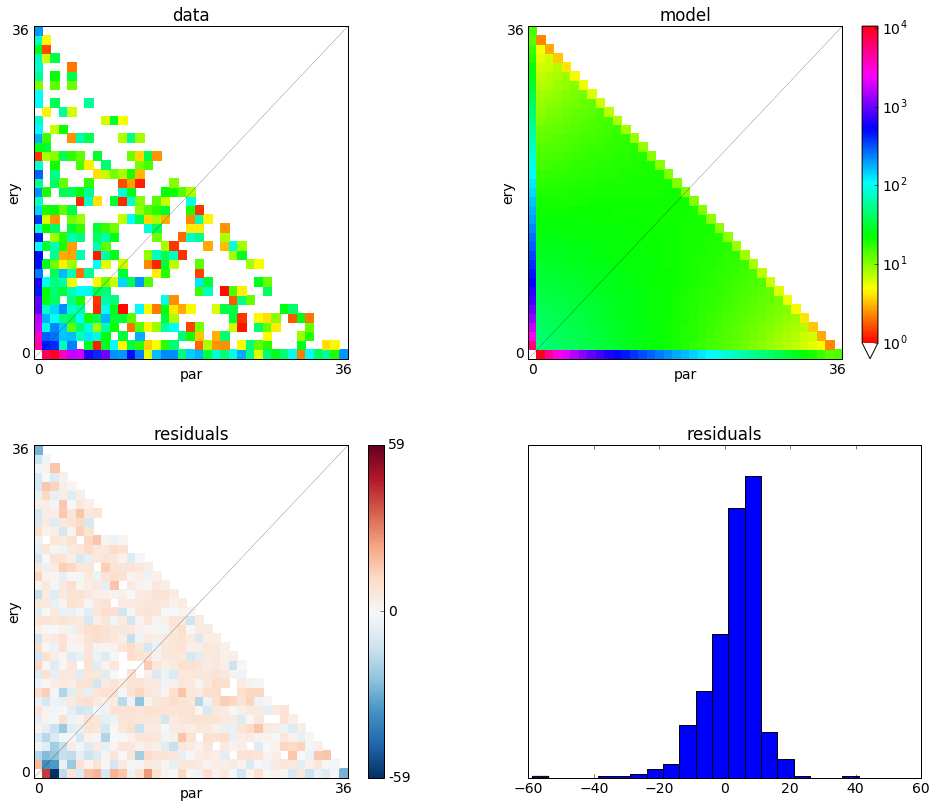

In [79]:
import pylab

pylab.rcParams['figure.figsize'] = [14.0, 12.0]
pylab.rcParams['font.size'] = 14.0

dadi.Plotting.plot_2d_comp_multinom(model_spectrum, sfs2d_folded, vmin=1)

A good computer screen is required to see the heatmap of the residuals in full detail.

The residuals show that the best-fit model has a deficit of fixed divergent SNP's as well as of low frequency shared SNP's.

Maybe the fit can be improved by introducing gene flow.

# divergence with migration model

In [156]:
?dadi.Demographics2D.split_mig

In [81]:
%%px --local

func = dadi.Demographics2D.split_mig

func_ex = dadi.Numerics.make_extrap_log_func(func)

In [82]:
%%px --local

# set up global variables on engines required for run_dadi function call

dadi_opt_func = dadi.Inference.optimize_log_fmin # uses Nelder-Mead algorithm
sfs = sfs2d_folded
perturb = True
fold = 2 # perturb randomly up to `fold` times 2-fold
maxiter = 10 # run a maximum of 10 iterations
verbose = 0
full_output = True # need to have full output to get the warnflags (see below)
outname = "OUT_2D_models/split_mig" # set file name stub for opt. result files

In [83]:
%%px --local

# set lower and upper bounds to nu1, nu2, T, m
upper_bound = [1e4, 1e4, 2, 10]
lower_bound = [1e-4, 1e-4, 0, 0]

In [84]:
# perturb these parameter values
# nu1, nu2, T, m
p0 = [0.5, 0.5, 0.1, 0.1] 
# split into equal proportions at >200,000 generations ago with 1 migrant individual per 10 generations

ar_split_mig_1 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [85]:
get_flag_count(ar_split_mig_1, NM=True)

success 0
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 10
unknown flag 0


In [86]:
%%px

fold = 3 # perturb randomly up to `fold` times 2-fold
maxiter = 100 # run a maximum of 10 iterations

In [87]:
# perturb these parameter values
p0 = [0.5, 0.5, 0.1, 0.1] 
# split into equal proportions at >200,000 generations ago with migrant one individual per 10 generations

ar_split_mig_1 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [88]:
get_flag_count(ar_split_mig_1, NM=True)

success 0
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 10
unknown flag 0


In [91]:
# perturb these parameter values
p0 = [0.5, 0.5, 0.1, 0.01] 
# split into equal proportions at >200,000 generations ago with one migrant individual per 100 generations

ar_split_mig_1 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [92]:
get_flag_count(ar_split_mig_1, NM=True)

success 0
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 10
unknown flag 0


In [93]:
# optimal parameters for nomig model: (0.636945, 1.229606, 0.290465)

# perturb parameter neutral values
p0 = [0.636945, 1.229606, 0.290465, 0.01] 
# split into equal proportions at >200,000 generations ago with migrant individual per 100 generations

ar_split_mig_1 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [94]:
get_flag_count(ar_split_mig_1, NM=True)

success 0
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 10
unknown flag 0


In [95]:
import numpy as np

In [97]:
m0 = np.logspace(-3, np.log10(5), base=10, num=20)
m0

array([  1.00000000e-03,   1.56560656e-03,   2.45112389e-03,
         3.83749564e-03,   6.00800835e-03,   9.40617727e-03,
         1.47263728e-02,   2.30557058e-02,   3.60961643e-02,
         5.65123915e-02,   8.84761707e-02,   1.38518873e-01,
         2.16866056e-01,   3.39526920e-01,   5.31565572e-01,
         8.32222546e-01,   1.30293308e+00,   2.03988057e+00,
         3.19365039e+00,   5.00000000e+00])

In [98]:
from itertools import product

In [109]:
p0 = [0.636945, 1.229606, 0.290465]

# do parameter sweep for migration rate
ar_split_mig_1 = lbview.map(run_dadi, [p0 + [m] for m in m0], block=False, order=False)

In [112]:
ar_split_mig_1.progress

19

In [113]:
get_flag_count(ar_split_mig_1, NM=True)

success 0
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 20
unknown flag 0


In [116]:
p0 = [0.636945, 1.229606, 0.290465, 1e-6]

ar_split_mig_1 = lbview.map(run_dadi, [p0], block=False, order=False)

In [117]:
get_flag_count(ar_split_mig_1, NM=True)

success 0
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 1
unknown flag 0


In [118]:
ar_split_mig_1.get()

[(array([  5.67647408e-01,   8.28132232e+00,   2.79617129e-01,
           7.13792423e-06]),
  (array([  6.37632787e-01,   1.22989019e+00,   2.90446980e-01,
            5.49800562e-07]), 20387.430473918725, 100, 178, 2))]

In [119]:
p0 = [0.636945, 1.229606, 0.290465, 1e-8]

ar_split_mig_1 = lbview.map(run_dadi, [p0], block=False, order=False)

In [120]:
ar_split_mig_1.get()

[(array([  4.69103735e+00,   6.98005316e+00,   2.34055747e-01,
           4.71573909e-09]),
  (array([  6.36962650e-01,   1.22844256e+00,   2.89937795e-01,
            9.28295473e-21]), 20387.445239922406, 100, 169, 2))]

In [122]:
%%px

maxiter = 500

In [123]:
# nu1, nu2, T, m:
p0 = [0.5, 0.5, 0.1, 1e-4]

ar_split_mig_1 = lbview.map(run_dadi, repeat(p0, 20), block=False, order=False)

In [124]:
get_flag_count(ar_split_mig_1, NM=True)

success 18
Maximum number of function evaluations made. 2
Maximum number of iterations reached. 0
unknown flag 0


Apparently, convergence of optimisation requires many more than 100 iterations.

In [125]:
success = [flatten(out)[:9] for out in ar_split_mig_1 if out[1][4] == 0]

df = pd.DataFrame(data=success, \
                  columns=['nu1_0','nu2_0', 'T_0', 'm_0', 'nu1_opt', 'nu2_opt', 'T_opt', 'm_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,nu1_0,nu2_0,T_0,m_0,nu1_opt,nu2_opt,T_opt,m_opt,-logL
3,0.837500,2.063526,0.058201,0.000110,0.996572,1.771058,0.928727,2.508888e-01,18574.138486
15,0.208178,2.525835,0.609693,0.000767,0.997653,1.771560,0.931469,2.510613e-01,18574.373801
14,1.009844,1.115355,0.012909,0.000309,0.992355,1.760054,0.901086,2.470464e-01,18574.974381
7,0.409099,0.405881,0.168447,0.000052,0.637198,1.230384,0.290581,6.497219e-08,20387.225419
11,2.175460,0.556770,0.086338,0.000014,0.637198,1.230385,0.290581,1.748376e-20,20387.226053
5,0.265271,0.129476,0.157514,0.000045,0.637196,1.230384,0.290580,2.583554e-12,20387.226053
6,0.085281,0.402881,0.364705,0.000042,0.637198,1.230385,0.290581,3.044384e-18,20387.226053
9,0.115098,0.103779,0.172020,0.000113,0.637162,1.230734,0.290565,4.850122e-15,20387.226666
17,3.731189,0.119188,0.015205,0.000017,0.637549,1.230015,0.290740,9.454649e-15,20387.229881
13,1.308999,0.089865,0.482895,0.000052,0.636599,1.228599,0.290307,4.483462e-10,20387.232239


The first three parameter combinations are much more likely than the remaining ones.

In [126]:
# extract optimal parameter combination

df.sort_values(by='-logL', ascending=True).iloc[0, 4:8]

nu1_opt    0.996572
nu2_opt    1.771058
T_opt      0.928727
m_opt      0.250889
Name: 3, dtype: float64

In [128]:
p0 = np.array(df.sort_values(by='-logL', ascending=True).iloc[0, 4:8])

ar_split_mig_2 = lbview.map(run_dadi, repeat(p0, 20), block=False, order=False)

In [129]:
ar_split_mig_2.progress

19

In [132]:
ar_split_mig_2.elapsed/60

25.53058113333333

In [134]:
import dill, glob

ar_split_mig_2 = []

for filename in glob.glob("OUT_2D_models/split_mig*dill"):
    ar_split_mig_2.append(dill.load(open(filename)))

In [137]:
success = [flatten(out)[:9] for out in ar_split_mig_2 if out[1][4] == 0]

df = pd.DataFrame(data=success, \
                  columns=['nu1_0','nu2_0', 'T_0', 'm_0', 'nu1_opt', 'nu2_opt', 'T_opt', 'm_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,nu1_0,nu2_0,T_0,m_0,nu1_opt,nu2_opt,T_opt,m_opt,-logL
8,2.059032,0.360002,0.682463,0.192790,0.994185,1.766127,0.922632,2.506880e-01,18574.119915
31,0.620927,0.849787,1.980000,1.827165,0.994247,1.766242,0.922690,2.507990e-01,18574.120405
2,2.894370,11.363772,1.980000,0.272765,0.993365,1.764405,0.921871,2.509119e-01,18574.121486
28,0.631049,2.924698,0.247732,0.205392,0.993307,1.765318,0.921817,2.509740e-01,18574.122241
17,0.837500,2.063526,0.058201,0.000110,0.996572,1.771058,0.928727,2.508888e-01,18574.138486
18,5.535163,3.398472,0.309525,0.169667,0.993863,1.767477,0.925657,2.517209e-01,18574.159471
15,0.318463,0.315764,0.587406,1.138654,0.989922,1.761280,0.914716,2.507331e-01,18574.164848
1,0.277233,8.221059,0.976626,0.051974,1.001148,1.776879,0.937823,2.505879e-01,18574.226541
0,5.653430,3.362330,1.980000,0.101259,0.995994,1.769480,0.927834,2.507786e-01,18574.341908
33,0.208178,2.525835,0.609693,0.000767,0.997653,1.771560,0.931469,2.510613e-01,18574.373801


Parameter combinations with neg. log likelihood of 20387 are almost identical to the `split-no-migration` from above. Adding some gene flow improves the likelihood of the model.

In [138]:
df.sort_values(by='-logL', ascending=True).iloc[0, 4:8]

nu1_opt    0.994185
nu2_opt    1.766127
T_opt      0.922632
m_opt      0.250688
Name: 8, dtype: float64

In [139]:
popt = np.array(df.sort_values(by='-logL', ascending=True).iloc[0, 4:8])

In [142]:
# calculate best-fit model spectrum

model_spectrum = func_ex(popt, ns, pts_l)

In [143]:
# log likelihood of the observed 2D spectrum given the model

ll_model = dadi.Inference.ll_multinom(model_spectrum, sfs2d_folded)

In [144]:
ll_model

-18574.119915473293

## plot

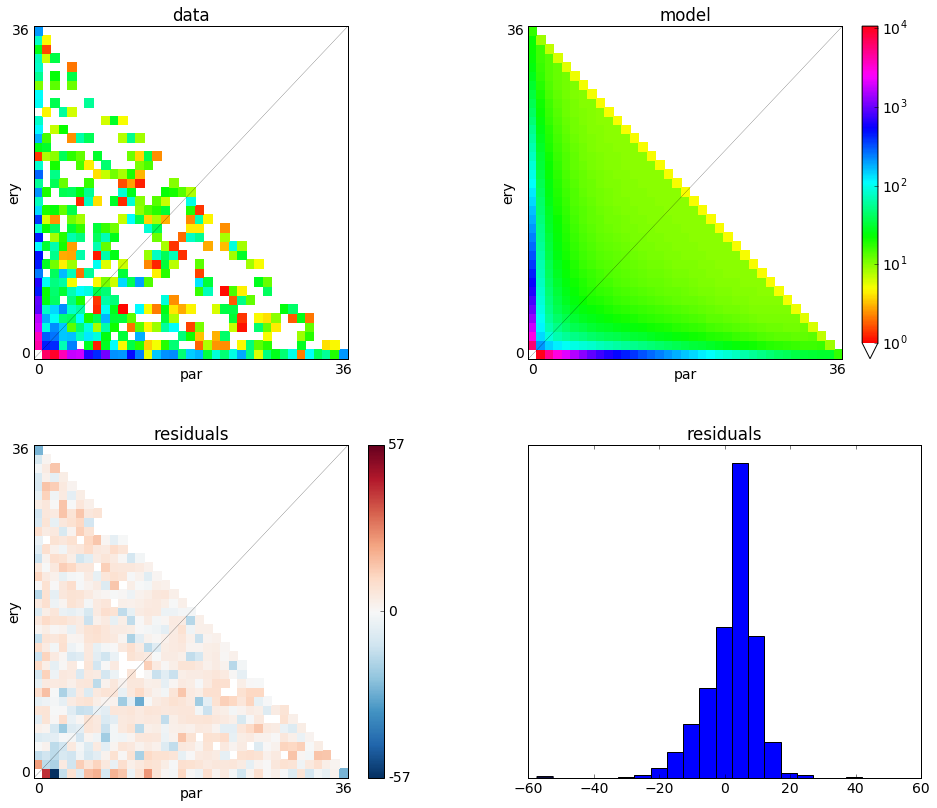

In [145]:
dadi.Plotting.plot_2d_comp_multinom(model_spectrum, sfs2d_folded, vmin=1)

This has reduced the residuals for low frequency shared polymorphisms, but the model still cannot fit divergently fixed SNP's well.

What does this model fit say in plain English:

In [165]:
print "The ancestral population split apart {2:,} generation ago. Since then, ery and par had a constant population size of {0:,} and {1:,}, respectively. The two diverging populations were exchanging one migrant in each direction every {3:.2f} genertions.".format(int(popt[0]*N_ref), int(popt[1]*N_ref), int(popt[2]*2*N_ref), 1.0/popt[3])

The ancestral population split apart 1,271,157 generation ago. Since then, ery and par had a constant population size of 684,870 and 1,216,642, respectively. The two diverging populations were exchanging one migrant in each direction every 3.99 genertions.


The dadi manual says about the migration rate parameter (on page 11):

>The migration parameter m12 specifies the rate of migration from pop 2 into pop 1. It is equal to the fraction of individuals each generation in pop 1 that are new migrants from pop 2, times the 2Nref.

So the migration rate has units of number of diploid immigrant individuals per generation.

## LRT

Is the model *with* migration significantly better than the model *without* migration?

From the dadi manual:

>The full likelihood ratio test statistic is equal to $D = 2(ll_c - ll_s)$ where $ll_c$ and $ll_s$ are the likelihoods of the complex and simple model, respectively.

$D$ should be $\chi^2$ distributed

>with degrees of freedom equal to the difference in number of parameters between the simple and complex model.

Not all SNP's in the spectrum will be unlinked with each other. Therefore, the *likelihoods* calculated are *composite likelihoods*. Dadi can calculate an adjustment factor for $D$ that corrects for linkage. However, this requires bootstrapped data sets, which I haven't created yet. In the following calculation I am assuming that all SNP's can be assumed independent data points.

In [169]:
ll_c = dadi.Inference.ll_multinom(model_spectrum, sfs2d_folded)

In [170]:
func = split_nomig

# create extrapolating version of the model function
func_ex = dadi.Numerics.make_extrap_log_func(func)

# calculate best-fit model spectrum with optimal parameter values
model_spectrum = func_ex((0.636945, 1.229606, 0.290465), ns, pts_l)

ll_s = dadi.Inference.ll_multinom(model_spectrum, sfs2d_folded)

In [173]:
D = 2*(ll_c - ll_s)
D

3626.2146620022322

In [177]:
# calculate p-value for Chi-square dist. with 1 degree of freedom
p = dadi.Godambe.sum_chi2_ppf(D)
p

0.0

Gene flow significantly improves the fit to the observed spectrum. I doubt that there could be enough linkage in the data to compromise this result.